# text image serach engine

> [Build a Milvus Powered Text-Image Search Engine in Minutes](https://github.com/towhee-io/examples/blob/07b8d446d26f3af371d8f3e8cb4fd91c9c0cd991/image/text_image_search/1_build_text_image_search_engine.ipynb)

## prepare the data

`pdm run data_reverse_image_search`

In [1]:
import pandas as pd

REVERSE_IMAGE_SEARCH_CSV_FILE = "./data/reverse_image_search.csv"

df = pd.read_csv(REVERSE_IMAGE_SEARCH_CSV_FILE)
df.head()

id                                          path        label
0   0  ./data/train/brain_coral/n01917289_1783.JPEG  brain_coral
1   1  ./data/train/brain_coral/n01917289_4317.JPEG  brain_coral
2   2   ./data/train/brain_coral/n01917289_765.JPEG  brain_coral
3   3  ./data/train/brain_coral/n01917289_1079.JPEG  brain_coral
4   4  ./data/train/brain_coral/n01917289_2484.JPEG  brain_coral

In [2]:
df["path"] = df["path"].str.replace("./train", "./data/train", regex=False)
df.head()

id                                          path        label
0   0  ./data/train/brain_coral/n01917289_1783.JPEG  brain_coral
1   1  ./data/train/brain_coral/n01917289_4317.JPEG  brain_coral
2   2   ./data/train/brain_coral/n01917289_765.JPEG  brain_coral
3   3  ./data/train/brain_coral/n01917289_1079.JPEG  brain_coral
4   4  ./data/train/brain_coral/n01917289_2484.JPEG  brain_coral

In [3]:
df.to_csv(REVERSE_IMAGE_SEARCH_CSV_FILE, index=False)

In [4]:
len(df)

1000

In [5]:
import cv2
from towhee._types.image import Image

id_img = df.set_index("id")["path"].to_dict()


def read_images(results):
    """
    read images by image IDs
    """
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), "BGR"))
    return imgs

/opt/homebrew/Caskroom/miniconda/base/envs/ml-playground/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 13.4 MB/s eta 0:00:00
  Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


onnx installed successfully!


## Create a Milvus Collection

Let's first create a text_image_search collection that uses the [L2 distance metric](https://milvus.io/docs/v2.0.x/metric.md#Euclidean-distance-L2) and an [IVF_FLAT index](https://milvus.io/docs/v2.0.x/index.md#IVF_FLAT).

In [6]:
from pymilvus import (
    Collection,
    CollectionSchema,
    DataType,
    FieldSchema,
    connections,
    utility,
)


def create_milvus_collection(collection_name, dim):
    connections.connect(host="127.0.0.1", port="19530")

    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)

    fields = [
        FieldSchema(
            name="id",
            dtype=DataType.INT64,
            descrition="ids",
            is_primary=True,
            auto_id=False,
        ),
        FieldSchema(
            name="embedding",
            dtype=DataType.FLOAT_VECTOR,
            descrition="embedding vectors",
            dim=dim,
        ),
    ]
    schema = CollectionSchema(fields=fields, description="text image search")
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        "metric_type": "L2",
        "index_type": "IVF_FLAT",
        "params": {"nlist": 512},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection


collection = create_milvus_collection("text_image_search", 512)

## Text Image Search

### Generate image and text embeddings with CLIP

In [7]:
import numpy as np
from towhee.dc2 import DataCollection, ops, pipe

  Using cached towhee.models-0.9.0-py3-none-any.whl (1.8 MB)
  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
  Using cached datasets-2.10.1-py3-none-any.whl (469 kB)
  Using cached tokenizers-0.13.2-cp39-cp39-macosx_12_0_arm64.whl (3.7 MB)
  Using cached huggingface_hub-0.12.1-py3-none-any.whl (190 kB)
  Using cached regex-2022.10.31-cp39-cp39-macosx_11_0_arm64.whl (287 kB)
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Using cached xxhash-3.2.0-cp39-cp39-macosx_11_0_arm64.whl (31 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
  Using cached multiprocess-0.70.14-py39-none-any.whl (132 kB)



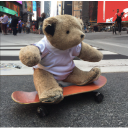

<Figure size 128x128 with 0 Axes>

In [8]:
p = (
    pipe.input("path")
    .map("path", "img", ops.image_decode.cv2("rgb"))
    .map(
        "img",
        "vec",
        ops.image_text_embedding.clip(
            model_name="clip_vit_base_patch16", modality="image"
        ),
    )
    .map("vec", "vec", lambda x: x / np.linalg.norm(x))
    .output("img", "vec")
)

DataCollection(p("./teddy.png")).show()

In [9]:
p2 = (
    pipe.input("text")
    .map(
        "text",
        "vec",
        ops.image_text_embedding.clip(
            model_name="clip_vit_base_patch16", modality="text"
        ),
    )
    .map("vec", "vec", lambda x: x / np.linalg.norm(x))
    .output("text", "vec")
)

DataCollection(p2("A teddybear on a skateboard in Times Square.")).show()

### Load Image Embeddings into Milvus

We first extract embeddings from images with `clip_vit_base_patch16` model and insert the embeddings into Milvus for indexing. 

In [10]:
%%time
collection = create_milvus_collection("text_image_search", 512)


def read_csv(csv_path, encoding="utf-8-sig"):
    import csv

    with open(csv_path, "r", encoding=encoding) as f:
        data = csv.DictReader(f)
        for line in data:
            yield int(line["id"]), line["path"]


p3 = (
    pipe.input("csv_file")
    .flat_map("csv_file", ("id", "path"), read_csv)
    .map("path", "img", ops.image_decode.cv2("rgb"))
    .map(
        "img",
        "vec",
        ops.image_text_embedding.clip(
            model_name="clip_vit_base_patch16", modality="image"
        ),
    )
    .map("vec", "vec", lambda x: x / np.linalg.norm(x))
    .map(
        ("id", "vec"),
        (),
        ops.ann_insert.milvus_client(
            host="127.0.0.1", port="19530", collection_name="text_image_search"
        ),
    )
    .output(tracer=True)
)

p3(REVERSE_IMAGE_SEARCH_CSV_FILE)

profiler_info = p3.profiler()
profiler_info.show()

Total count:  1
Total time(s):  87.3393
Avg time(s):  87.3393
Max time(s):  87.3393
Min time(s):  87.3393
node                                ncalls    total_time(s)    init(s)    wait_data(s)    call_op(s)     output_data(s)
--------------------------------  --------  ---------------  ---------  --------------  ------------  -----------------
_input(map)                              1           0.0001          0          0             0                  0
read_csv-0(flat_map)                     1           0.0063          0          0             0.0063             0
image-decode/cv2-1(map)               1000           1.9966          0          0.0173        1.9712             0.0081
image-text-embedding/clip-2(map)      1000          87.2639          0          0.042        87.2122             0.0098
lambda-3(map)                         1000          87.3064          0         87.2505        0.052              0.0039
ann-insert/milvus-client-4(map)       1000          87.3179     

In [11]:
collection.load()

In [12]:
print(f"Total number of inserted data is {collection.num_entities}.")

Total number of inserted data is 0.


### Query Matched Images from Milvus


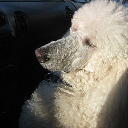
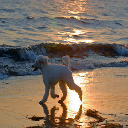
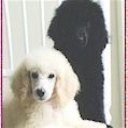
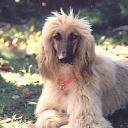
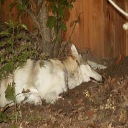


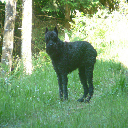
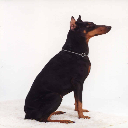
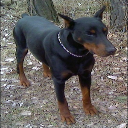
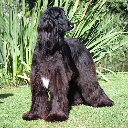
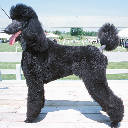

In [14]:
import cv2
import pandas as pd


def read_image(image_ids):
    df = pd.read_csv(REVERSE_IMAGE_SEARCH_CSV_FILE)
    id_img = df.set_index("id")["path"].to_dict()
    imgs = []
    decode = ops.image_decode.cv2("rgb")
    for image_id in image_ids:
        path = id_img[image_id]
        imgs.append(decode(path))
    return imgs


p4 = (
    pipe.input("text")
    .map(
        "text",
        "vec",
        ops.image_text_embedding.clip(
            model_name="clip_vit_base_patch16", modality="text"
        ),
    )
    .map("vec", "vec", lambda x: x / np.linalg.norm(x))
    .map(
        "vec",
        "result",
        ops.ann_search.milvus_client(
            host="127.0.0.1", port="19530", collection_name="text_image_search", limit=5
        ),
    )
    .map("result", "image_ids", lambda x: [item[0] for item in x])
    .map("image_ids", "images", read_image)
    .output("text", "images")
)

DataCollection(p4("A white dog")).show()
DataCollection(p4("A black dog")).show()

## Release a Showcase

In [15]:
search_pipeline = (
    pipe.input("text")
    .map(
        "text",
        "vec",
        ops.image_text_embedding.clip(
            model_name="clip_vit_base_patch16", modality="text"
        ),
    )
    .map("vec", "vec", lambda x: x / np.linalg.norm(x))
    .map(
        "vec",
        "result",
        ops.ann_search.milvus_client(
            host="127.0.0.1", port="19530", collection_name="text_image_search", limit=5
        ),
    )
    .map("result", "image_ids", lambda x: [item[0] for item in x])
    .output("image_ids")
)


def search(text):
    df = pd.read_csv(REVERSE_IMAGE_SEARCH_CSV_FILE)
    id_img = df.set_index("id")["path"].to_dict()
    imgs = []
    image_ids = search_pipeline(text).to_list()[0][0]
    return [id_img[image_id] for image_id in image_ids]

In [16]:
import gradio

interface = gradio.Interface(
    search,
    gradio.inputs.Textbox(lines=1),
    [gradio.outputs.Image(type="filepath", label=None) for _ in range(5)],
)

interface.launch(inline=True, share=False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
